In [1]:
import openmc

# Advanced Tallies

In [2]:
model = openmc.examples.pwr_assembly()

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

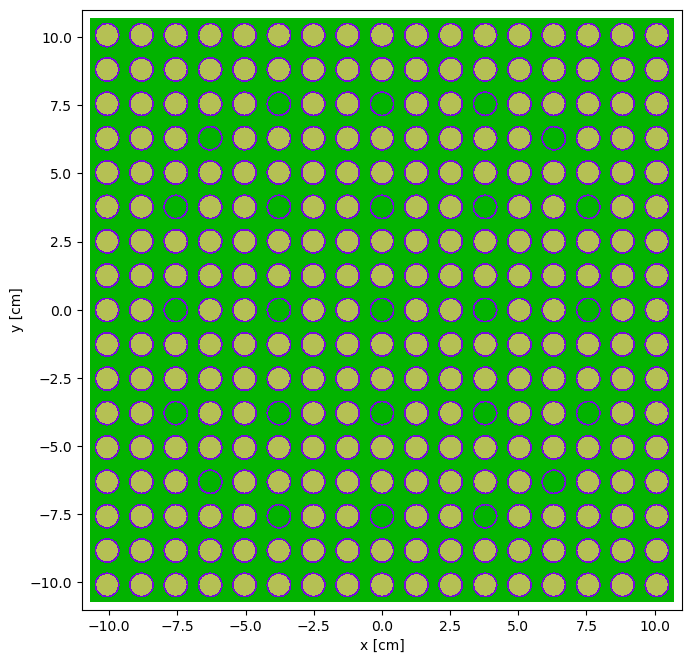

In [4]:
model.geometry.root_universe.plot(width=(22,22), pixels=(600,600), color_by='material')

In [5]:
model.materials

[Material
 	ID             =	1
 	Name           =	Fuel
 	Temperature    =	None
 	Density        =	10.29769 [g/cm3]
 	Volume         =	None [cm^3]
 	Depletable     =	True
 	S(a,b) Tables  
 	Nuclides       
 	U234           =	4.4843e-06   [ao]
 	U235           =	0.00055815   [ao]
 	U238           =	0.022408     [ao]
 	O16            =	0.045829     [ao],
 Material
 	ID             =	2
 	Name           =	Cladding
 	Temperature    =	None
 	Density        =	6.55 [g/cm3]
 	Volume         =	None [cm^3]
 	Depletable     =	False
 	S(a,b) Tables  
 	Nuclides       
 	Zr90           =	0.021827     [ao]
 	Zr91           =	0.00476      [ao]
 	Zr92           =	0.0072758    [ao]
 	Zr94           =	0.0073734    [ao]
 	Zr96           =	0.0011879    [ao],
 Material
 	ID             =	3
 	Name           =	Hot borated water
 	Temperature    =	None
 	Density        =	0.740582 [g/cm3]
 	Volume         =	None [cm^3]
 	Depletable     =	False
 	S(a,b) Tables  
 	S(a,b)         =	('c_H_in_H2O', 1.0)
 	Nuclides 

In [7]:
surfaces = model.geometry.get_all_surfaces()
type(surfaces)

dict

In [8]:
for surf_id, surface in surfaces.items():
    if isinstance(surface, openmc.YPlane) and surface.y0 > 0:
        surface.boundary_type = 'vacuum'
    if isinstance(surface, openmc.XPlane) and surface.x0 > 0:
        surface.boundary_type = 'vacuum'

## Mesh Tallies

In [9]:
mesh = openmc.RegularMesh()

In [10]:
lower_left, upper_right = model.geometry.bounding_box
print(lower_left, upper_right)

[-10.71 -10.71   -inf] [10.71 10.71   inf]


In [11]:
mesh.lower_left = lower_left[:2]
mesh.upper_right = upper_right[:2]
mesh.dimension = (50,50)

In [12]:
mesh_filter = openmc.MeshFilter(mesh)

In [13]:
mesh_tally = openmc.Tally()
mesh_tally.filters = [mesh_filter]
mesh_tally.scores = ['flux', 'heating']

In [29]:
model.tallies = [mesh_tally]

model.settings.particles = 10000
model.settings.batches = 150
model.settings.inactive = 100

In [30]:
statepoint = model.run(output=False)

In [31]:
with openmc.StatePoint(statepoint) as sp:
    mesh_tally_out = sp.get_tally(id=mesh_tally.id)

In [32]:
mesh_tally_out.shape

(2500, 1, 2)

In [33]:
mesh_flux = mesh_tally_out.get_values(scores=['flux'])

mesh_flux = mesh_flux.reshape(mesh.dimension)
mesh_flux.shape

(50, 50)

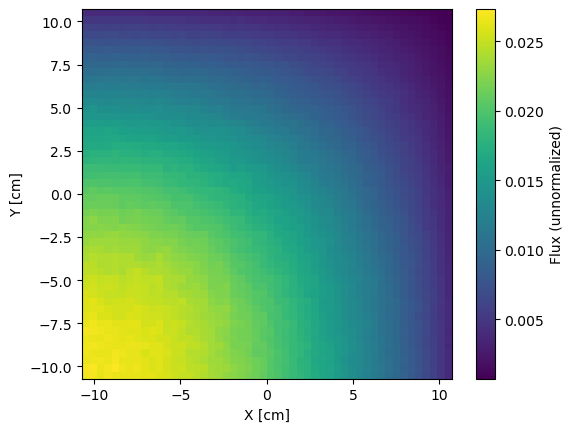

In [34]:
import matplotlib.pyplot as plt
img = plt.imshow(mesh_flux, origin='lower', extent=[-10.71, 10.71, -10.71, 10.71])
plt.xlabel('X [cm]')
plt.ylabel('Y [cm]')
plt.colorbar(img, label='Flux (unnormalized)')

In [39]:
heating = mesh_tally_out.get_values(scores=['heating']).sum() # total heating in eV/source particle

J_to_ev = 1 / 1.602e-19
power = 17.34e6
neutron_source = power * J_to_ev / heating

print(neutron_source)

1.9267845485538066e+18


In [38]:
import numpy as np

volume = np.prod((mesh.upper_right - mesh.lower_left) / mesh.dimension)
print(volume)

0.18352656000000006


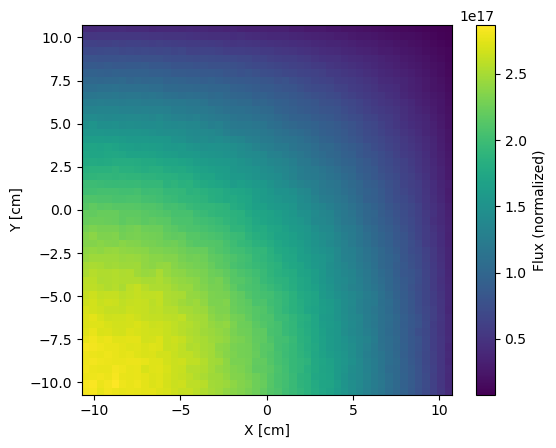

In [40]:
img = plt.imshow(mesh_flux * neutron_source / volume, origin='lower', extent=[-10.71, 10.71, -10.71, 10.71])
plt.xlabel('X [cm]')
plt.ylabel('Y [cm]')
plt.colorbar(img, label='Flux (normalized)')

In [44]:
mesh_heat = mesh_tally_out.get_values(scores=['heating']) * neutron_source / volume * 1.602e-19
mesh_heat = mesh_heat.reshape(mesh.dimension)
mesh_heat.shape

(50, 50)

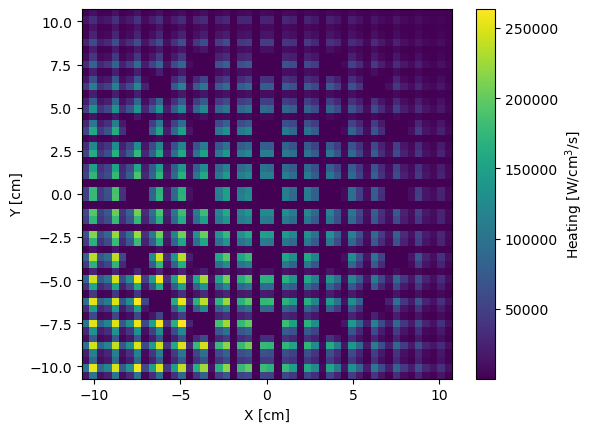

In [46]:
img = plt.imshow(mesh_heat, origin='lower', extent=[-10.71, 10.71, -10.71, 10.71])
plt.xlabel('X [cm]')
plt.ylabel('Y [cm]')
plt.colorbar(img, label='Heating [W/cm$^3$/s]')

### Manipulating the Tally Arrays

In [47]:
mesh_tally_out.shape

(2500, 1, 2)

In [48]:
mesh_tally_out.get_reshaped_data().shape

(2500, 1, 2)

In [50]:
mesh_data = mesh_tally_out.get_reshaped_data(expand_dims=True)
mesh_data.shape

(50, 50, 1, 2)

In [52]:
mesh_data[0,0] # both scores at each point in the grid

array([[2.68023243e-02, 1.01477416e+04]])

In [53]:
flux_only = mesh_tally_out.get_slice(scores=['flux'])
flux_only.shape

(2500, 1, 1)

In [54]:
flux_reshaped = flux_only.get_reshaped_data(expand_dims=True).squeeze()
flux_reshaped.shape

(50, 50)

In [55]:
flux_reshaped[0,0]

0.02680232425985321

## Distributed Cells (distribcells)

In [57]:
fuel_cell = None

for cell_id, cell in model.geometry.get_all_material_cells().items():
    if cell.fill.name == 'Fuel':
        fuel_cell = cell

print(fuel_cell)

Cell
	ID             =	1
	Name           =	fuel
	Fill           =	Material 1
	Region         =	-1
	Rotation       =	None
	Temperature    =	None
	Translation    =	None
	Volume         =	None



In [59]:
model.geometry.determine_paths()
print(fuel_cell.num_instances)

264


In [60]:
17*17 - 25

264

In [61]:
distribcell_filter = openmc.DistribcellFilter(fuel_cell)

In [62]:
dcell_tally = openmc.Tally()
dcell_tally.filters = [distribcell_filter]
dcell_tally.scores = ['heating']

In [63]:
model.tallies = [dcell_tally]

In [64]:
statepoint = model.run(output=False)

In [65]:
with openmc.StatePoint(statepoint) as sp:
    dcell_tally_out = sp.get_tally(id=dcell_tally.id)

In [67]:
heat = dcell_tally_out.get_values(scores=['heating'])
heat.shape

(264, 1, 1)

In [79]:
heat_df = dcell_tally_out.get_pandas_dataframe()
heat_df

level 1      level 2         level 3      distribcell nuclide    score  \
       univ cell     lat            univ cell                                
         id   id      id   x   y      id   id                                
0         4    7       3   0   0       1    1           0   total  heating   
1         4    7       3   1   0       1    1           1   total  heating   
2         4    7       3   2   0       1    1           2   total  heating   
3         4    7       3   3   0       1    1           3   total  heating   
4         4    7       3   4   0       1    1           4   total  heating   
..      ...  ...     ...  ..  ..     ...  ...         ...     ...      ...   
259       4    7       3  12  16       1    1         259   total  heating   
260       4    7       3  13  16       1    1         260   total  heating   
261       4    7       3  14  16       1    1         261   total  heating   
262       4    7       3  15  16       1    1         262   total  heating   
263       4    7       3  16  16       1    1         263   total  heating   

        mean std. dev.  
                        
                        
0   4.02e+05  8.32e+03  
1   4.03e+05  7.14e+03  
2   4.11e+05  5.81e+03  
3   3.92e+05  6.60e+03  
4   3.77e+05  6.30e+03  
..       ...       ...  
259 3.31e+04  1.73e+03  
260 2.42e+04  1.35e+03  
261 2.16e+04  1.41e+03  
262 1.56e+04  1.20e+03  
263 8.58e+03  6.52e+02  

[264 rows x 12 columns]

In [80]:
print(fuel_cell.region)

-1


In [81]:
surface = model.geometry.get_all_surfaces()
print(surfaces)

{3: Surface
	ID                 =	3
	Name               =	
	Type               =	x-plane
	Boundary           =	reflective
	Coefficients       
x0                  =	-10.71
, 4: Surface
	ID                 =	4
	Name               =	
	Type               =	x-plane
	Boundary           =	vacuum
	Coefficients       
x0                  =	10.71
, 5: Surface
	ID                 =	5
	Name               =	
	Type               =	y-plane
	Boundary           =	reflective
	Coefficients       
y0                  =	-10.71
, 6: Surface
	ID                 =	6
	Name               =	
	Type               =	y-plane
	Boundary           =	vacuum
	Coefficients       
y0                  =	10.71
, 1: Surface
	ID                 =	1
	Name               =	Fuel OR
	Type               =	z-cylinder
	Boundary           =	transmission
	Coefficients       
x0                  =	0
y0                  =	0
r                   =	0.39218
, 2: Surface
	ID                 =	2
	Name               =	Clad OR
	Type             

In [82]:
print(surfaces[1])

Surface
	ID                 =	1
	Name               =	Fuel OR
	Type               =	z-cylinder
	Boundary           =	transmission
	Coefficients       
x0                  =	0
y0                  =	0
r                   =	0.39218



In [83]:
volume = np.pi * 0.39218**2

In [84]:
heat_df['power [W/cc]'] = power * heat_df['mean'] / heating

In [85]:
heat_df

level 1      level 2         level 3      distribcell nuclide    score  \
       univ cell     lat            univ cell                                
         id   id      id   x   y      id   id                                
0         4    7       3   0   0       1    1           0   total  heating   
1         4    7       3   1   0       1    1           1   total  heating   
2         4    7       3   2   0       1    1           2   total  heating   
3         4    7       3   3   0       1    1           3   total  heating   
4         4    7       3   4   0       1    1           4   total  heating   
..      ...  ...     ...  ..  ..     ...  ...         ...     ...      ...   
259       4    7       3  12  16       1    1         259   total  heating   
260       4    7       3  13  16       1    1         260   total  heating   
261       4    7       3  14  16       1    1         261   total  heating   
262       4    7       3  15  16       1    1         262   total  heating   
263       4    7       3  16  16       1    1         263   total  heating   

        mean std. dev. power [W/cc]  
                                     
                                     
0   4.02e+05  8.32e+03     1.24e+05  
1   4.03e+05  7.14e+03     1.24e+05  
2   4.11e+05  5.81e+03     1.27e+05  
3   3.92e+05  6.60e+03     1.21e+05  
4   3.77e+05  6.30e+03     1.16e+05  
..       ...       ...          ...  
259 3.31e+04  1.73e+03     1.02e+04  
260 2.42e+04  1.35e+03     7.48e+03  
261 2.16e+04  1.41e+03     6.67e+03  
262 1.56e+04  1.20e+03     4.80e+03  
263 8.58e+03  6.52e+02     2.65e+03  

[264 rows x 13 columns]

# Best Practices

## Lattices vs Flat Geometries

In [1]:
import openmc

model = openmc.Model()
model.settings.particles = 10_000
model.settings.inactive = 50
model.settings.batches = 100

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

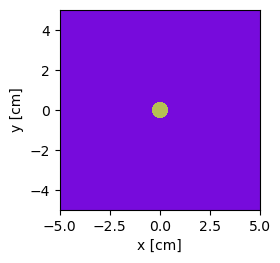

In [4]:
mat1 = openmc.Material()
mat1.add_element('U', 1.0)
mat1.set_density('g/cc', 11.)

mat2 = openmc.Material()
mat2.add_nuclide('Pu239', 1.0)
mat2.set_density('g/cc', 11.)

zcyl = openmc.ZCylinder(r=.4)
cyl = openmc.Cell(fill=mat1, region=-zcyl)
ocyl = openmc.Cell(fill=mat2, region=+zcyl)

univ = openmc.Universe(cells=[cyl, ocyl])
univ.plot(width=(10,10))

In [6]:
N = 50
pitch = 1

### Option 1: Lattice (good way)

In [7]:
lattice = openmc.RectLattice()
lattice.lower_left = (-N*pitch/2, -N*pitch/2)
lattice.pitch = (pitch,pitch)
lattice.universes = [[univ] * N] * N
lattice.universes.shape

(50, 50)

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

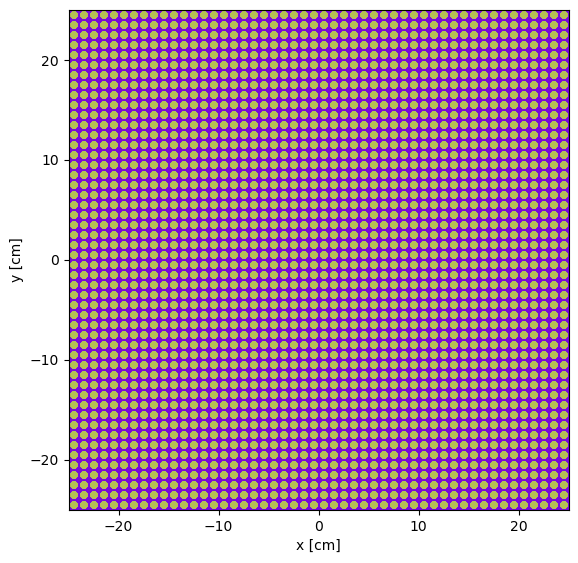

In [9]:
bound = openmc.model.RectangularPrism(N*pitch, N*pitch, boundary_type='reflective')
root_universe1 = openmc.Universe(cells=[openmc.Cell(region=-bound, fill=lattice)])

root_universe1.plot(width=(N*pitch,N*pitch), color_by='material', pixels=(500,500))

In [6]:
model.geometry = openmc.Geometry(root_universe1)

In [7]:
statepoint = model.run()

[v5:192476] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
 

### Option 2: "Flat" Geometry (evil demon way)

In [8]:
import numpy as np

xplanes = [openmc.XPlane(x0=x) for x in np.linspace(-N*pitch/2, N*pitch/2, N+1)]
yplanes = [openmc.YPlane(y0=y) for y in np.linspace(-N*pitch/2, N*pitch/2, N+1)]

xplanes[0].boundary_type = 'reflective'
xplanes[-1].boundary_type = 'reflective'
yplanes[0].boundary_type = 'reflective'
yplanes[-1].boundary_type = 'reflective'

In [9]:
cells = []
for x in range(len(xplanes) - 1):
    for y in range(len(yplanes) - 1):
        left = xplanes[x]
        right = xplanes[x + 1]
        bottom = yplanes[y]
        top = yplanes[y + 1]

        region = +left & -right & +bottom & -top

        x0 = (xplanes[x].x0 + xplanes[x+1].x0) / 2
        y0 = (yplanes[y].y0 + yplanes[y+1].y0) / 2

        cylinder = openmc.ZCylinder(x0=x0, y0=y0, r=0.4)

        cells.append(openmc.Cell(region=-cylinder, fill=mat1))
        cells.append(openmc.Cell(region=+cylinder & region, fill=mat2))

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

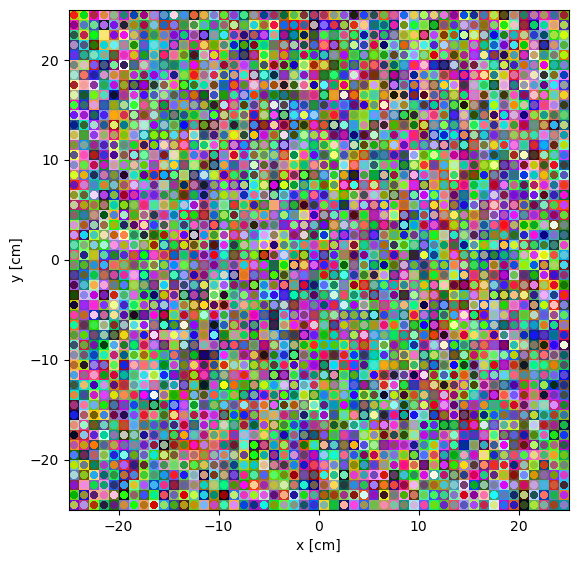

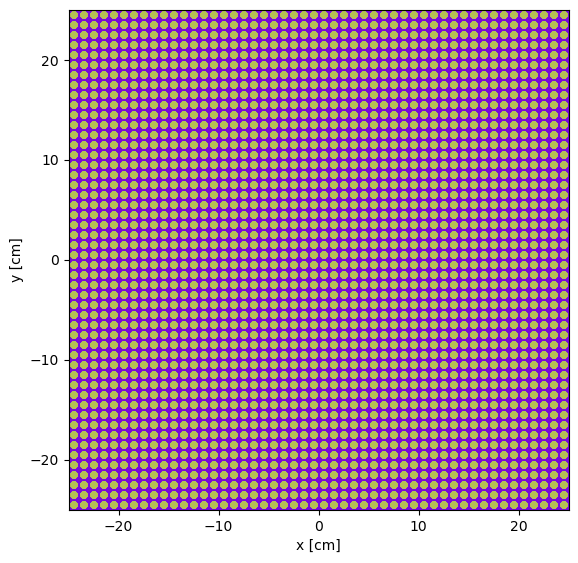

In [10]:
root_universe2 = openmc.Universe(cells=cells)
root_universe2.plot(width=(N*pitch,N*pitch), pixels=(500,500))
root_universe2.plot(width=(N*pitch,N*pitch), pixels=(500,500), color_by='material')

In [11]:
model.geometry = openmc.Geometry(root_universe2)
statepoint = model.run()

[v5:192589] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
 

## Using OpenMC Correctly

### Inactive Batches and Initial Source

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

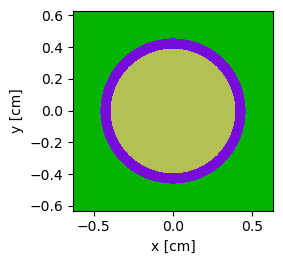

In [2]:
model = openmc.examples.pwr_pin_cell()
model.geometry.root_universe.plot()

In [3]:
model.geometry.bounding_box

BoundingBox(lower_left=(-0.63, -0.63, -inf), upper_right=(0.63, 0.63, inf))

In [4]:
bottom = openmc.ZPlane(z0=-150, boundary_type='vacuum')
top = openmc.ZPlane(z0=150, boundary_type='vacuum')
box = openmc.model.RectangularPrism(0.63*2, 0.63*2, boundary_type='reflective')
outer_cell = openmc.Cell(region=-box & +bottom & -top, fill=model.geometry.root_universe)
root_universe = openmc.Universe(cells=[outer_cell])
model.geometry.root_universe = root_universe

In [5]:
x = openmc.stats.Uniform(-0.63, 0.63)
y = openmc.stats.Uniform(-0.63, 0.63)
z = openmc.stats.Uniform(-150, 0)
space = openmc.stats.CartesianIndependent(x=x, y=y, z=z)
model.settings.source = openmc.IndependentSource(space=space)

In [12]:
heat = openmc.Tally()
heat.scores = ['kappa-fission']

mesh = openmc.RegularMesh()
mesh.lower_left = (-0.63,-0.63,-150)
mesh.upper_right = (0.63,0.63,150)
mesh.dimension = (1,1,50) # linear as a function of z

heat.filters = [openmc.MeshFilter(mesh=mesh)]

model.tallies = [heat]

In [13]:
import matplotlib.pyplot as plt

Text(0, 0.5, 'Kappa-Fission (unnormalized)')

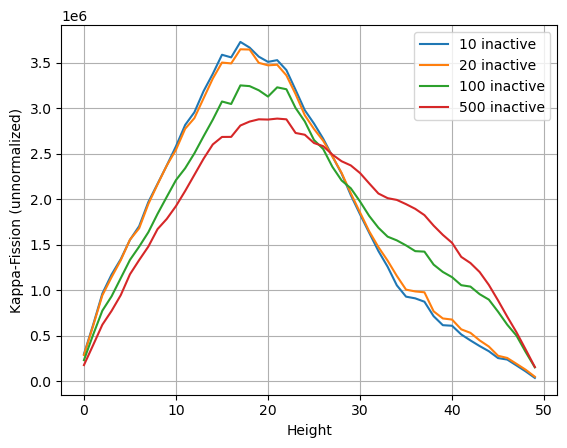

In [14]:
model.settings.particles = 1000

fig, ax = plt.subplots()

for i in [10, 20, 100, 500]:
    model.settings.batches = i + 100
    statepoint = model.run(output=False)

    with openmc.StatePoint(statepoint) as sp:
        t = sp.get_tally(id=heat.id)

    ax.plot(t.get_values().flatten(), label='{} inactive'.format(i))

plt.legend()
plt.grid()
plt.xlabel('Height')
plt.ylabel('Kappa-Fission (unnormalized)')

In [15]:
z = openmc.stats.Uniform(-150,150)
space = openmc.stats.CartesianIndependent(x=x,y=y,z=z)
model.settings.source = openmc.IndependentSource(space=space)

Text(0, 0.5, 'Kappa-Fission (unnormalized')

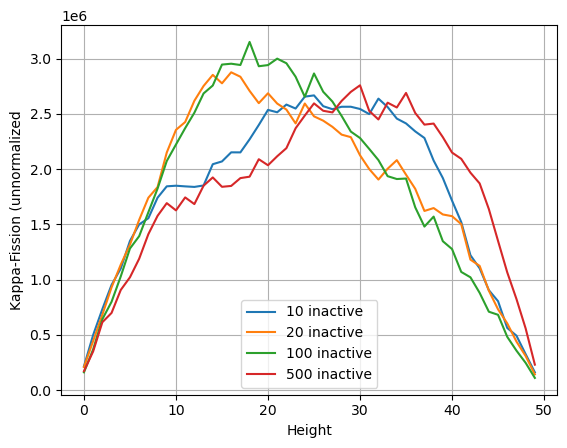

In [16]:
model.settings.particles = 1000

fig,ax = plt.subplots()

for i in [10,20,100,500]:
    # run OpenMC multiple times
    model.settings.inactive = i
    model.settings.batches = i + 100

    statepoint = model.run(output=False)

    with openmc.StatePoint(statepoint) as sp:
        t = sp.get_tally(id=heat.id)
    
    ax.plot(t.get_values().flatten(), label='{} inactive'.format(i))

plt.legend()
plt.grid()
plt.xlabel('Height')
plt.ylabel('Kappa-Fission (unnormalized')

## Shannon Entropy

In [25]:
model.settings.entropy_mesh = mesh

In [26]:
statepoint = model.run()

[v5:195157] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
 

Text(0, 0.5, 'Shannon Entropy')

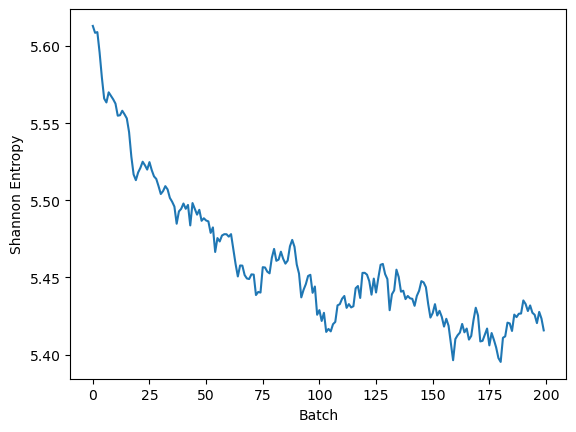

In [27]:
with openmc.StatePoint(statepoint) as sp:
    entropy = sp.entropy

plt.plot(entropy)
plt.xlabel('Batch')
plt.ylabel('Shannon Entropy')

Text(0, 0.5, 'Shannon entropy')

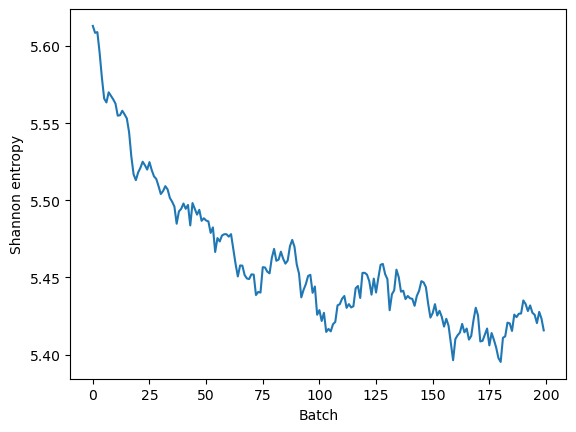

In [28]:
model.settings.particles = 10000
statepoint = model.run(output=False)
with openmc.StatePoint(statepoint) as sp:
    entropy = sp.entropy

plt.plot(entropy)
plt.xlabel('Batch')
plt.ylabel('Shannon entropy')

## Active Batches

In [29]:
model.settings = openmc.Settings()

space = openmc.stats.CartesianIndependent(x=x, y=y, z=z)
model.settings.source = openmc.IndependentSource(space=space)

model.settings.inactive = 100
model.settings.batches = 200
model.settings.particles = 500
statepoint = model.run()

[v5:195376] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
 

### Tally Triggers

In [30]:
with openmc.StatePoint(statepoint) as sp:
    h = sp.get_tally(id=heat.id)

tally_values = h.get_values(value='rel_err').flatten()
print(tally_values.max())
# get to 1%

0.16633389242067528


In [31]:
trigger = openmc.Trigger('rel_err', 0.07)
heat.trigger = [trigger]
model.tallies = [heat]

In [32]:
model.settings.trigger_active = True
model.settings.trigger_batch_interval = 5
model.settings.trigger_max_batches = 1000

In [33]:
statepoint = model.run()

[v5:195452] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
 

In [34]:
with openmc.StatePoint(statepoint) as sp:
    h = sp.get_tally(id=heat.id)

tally_values = h.get_values(value='rel_err').flatten()
print(tally_values.max())

0.16633389242067528


In [35]:
model.settings.keff_trigger = {'type': 'std_dev', 'threshold': 0.00200}

In [36]:
statepoint = model.run()

[v5:195520] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)
                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
 

## Inter-Cycle Correlation

In [37]:
model.tallies = []

model.settings.trigger_active = False
model.settings.inactive = 10
model.settings.batches = 110
model.settings.particles = 4000

In [39]:
n = 1

k_values = []
k_std_dev_values = []
while n <= 5:
    #run OpenMC with different seeds
    model.settings.seed = n
    statepoint = model.run(output=False)

    with openmc.StatePoint(statepoint) as sp:
        k_values.append(sp.keff.nominal_value)
        k_std_dev_values.append(sp.keff.std_dev)
    
    print('Ran OpenMC with seed = {0} ... k = {1} +/- {2}'.format(n, k_values[-1], k_std_dev_values[-1]))

    n += 1

Ran OpenMC with seed = 1 ... k = 1.1570732435508506 +/- 0.0014305436063443379
Ran OpenMC with seed = 2 ... k = 1.1533569631703002 +/- 0.0015955955632283654
Ran OpenMC with seed = 3 ... k = 1.1502742568830258 +/- 0.0013169427603656795
Ran OpenMC with seed = 4 ... k = 1.1539265015886255 +/- 0.0012356394353190267
Ran OpenMC with seed = 5 ... k = 1.1575739015225095 +/- 0.0013759075175979526


In [40]:
import numpy as np

mean = np.mean(k_values)
std_dev = np.std(k_values)

print(mean, std_dev)

1.1544409733430623 0.002666284708109343


In [41]:
# fix this correlation with more generations per batch
model.settings.generations_per_batch = 2

In [44]:
n = 1

k_values = []
k_std_dev_values = []
while n <= 5:
    model.settings.seed = n
    statepoint = model.run(output=False)

    with openmc.StatePoint(statepoint) as sp:
        k_values.append(sp.keff.nominal_value)
        k_std_dev_values.append(sp.keff.std_dev)

    print('Running OpenMC with seed = {0} ... k = {1} +/- {2}'.format(n, k_values[-1], k_std_dev_values[-1]))

    n += 1

Running OpenMC with seed = 1 ... k = 1.1534692818285013 +/- 0.0010216392393608466
Running OpenMC with seed = 2 ... k = 1.1529450891627078 +/- 0.00105068151445988
Running OpenMC with seed = 3 ... k = 1.1541096697456725 +/- 0.0011352316403770307
Running OpenMC with seed = 4 ... k = 1.1550883260381077 +/- 0.0010095490966991495
Running OpenMC with seed = 5 ... k = 1.1548777335606737 +/- 0.001070388392430717


In [45]:
mean = np.mean(k_values)
std_dev = np.std(k_values)

print(mean, std_dev)

1.1540980200671327 0.0008140462156738053


# Depletion, Activation, and Decay

In [66]:
!rm geometry.xml settings.xml tallies.xml model.xml plots.xml

rm: cannot remove 'geometry.xml': No such file or directory
rm: cannot remove 'settings.xml': No such file or directory
rm: cannot remove 'tallies.xml': No such file or directory
rm: cannot remove 'plots.xml': No such file or directory


In [2]:
import os
if (not os.path.isfile("chain_simple.xml")):
  raise ValueError("Installation of Depletion Chains was not completed!")
else:
  print("Installation Completed")

Installation Completed


In [3]:
import math
import matplotlib.pyplot as plt
import openmc.deplete

[v5:213960] mca_base_component_repository_open: unable to open mca_btl_openib: librdmacm.so.1: cannot open shared object file: No such file or directory (ignored)


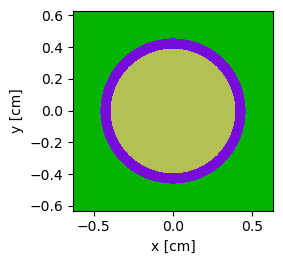

In [4]:
model = openmc.examples.pwr_pin_cell()
model.geometry.root_universe.plot(width=(1.26, 1.26))

model.settings.particles = 1000
model.settings.inactive = 10
model.settings.batches = 50

In [5]:
for i, k in model.geometry.get_all_cells().items():
    if (k.name == 'Fuel'):
        fuel = i
        print(k)

fuel_material = model.geometry.get_all_cells()[fuel].fill

Cell
	ID             =	1
	Name           =	Fuel
	Fill           =	Material 1
	Region         =	-1
	Rotation       =	None
	Temperature    =	None
	Translation    =	None
	Volume         =	None



In [6]:
fuel_material.volume = math.pi * 0.63 **2

In [7]:
print(model.materials)

[Material
	ID             =	1
	Name           =	UO2 (2.4%)
	Temperature    =	None
	Density        =	10.29769 [g/cm3]
	Volume         =	1.246898124209789 [cm^3]
	Depletable     =	True
	S(a,b) Tables  
	Nuclides       
	U234           =	4.4843e-06   [ao]
	U235           =	0.00055815   [ao]
	U238           =	0.022408     [ao]
	O16            =	0.045829     [ao]
, Material
	ID             =	2
	Name           =	Zircaloy
	Temperature    =	None
	Density        =	6.55 [g/cm3]
	Volume         =	None [cm^3]
	Depletable     =	False
	S(a,b) Tables  
	Nuclides       
	Zr90           =	0.021827     [ao]
	Zr91           =	0.00476      [ao]
	Zr92           =	0.0072758    [ao]
	Zr94           =	0.0073734    [ao]
	Zr96           =	0.0011879    [ao]
, Material
	ID             =	3
	Name           =	Hot borated water
	Temperature    =	None
	Density        =	0.740582 [g/cm3]
	Volume         =	None [cm^3]
	Depletable     =	False
	S(a,b) Tables  
	S(a,b)         =	('c_H_in_H2O', 1.0)
	Nuclides       
	H1     

## The Chain Class

In [8]:
!cat chain_simple.xml

<?xml version="1.0"?>
<depletion_chain>
  <nuclide name="I135" decay_modes="1" reactions="1" half_life="2.36520E+04">
    <decay type="beta" target="Xe135" branching_ratio="1.0" />
    <reaction type="(n,gamma)" Q="0.0" target="Xe136" /> <!-- Not precisely true, but whatever -->
  </nuclide>
  <nuclide name="Xe135" decay_modes="1" reactions="1" half_life="3.29040E+04">
    <decay type=" beta" target="Cs135" branching_ratio="1.0" />
    <reaction type="(n,gamma)" Q="0.0" target="Xe136" />
  </nuclide>
  <nuclide name="Xe136" decay_modes="0" reactions="0" />
  <nuclide name="Cs135" decay_modes="0" reactions="0" />
  <nuclide name="Gd157" decay_modes="0" reactions="1"  >
    <reaction type="(n,gamma)" Q="0.0" target="Nothing" />
  </nuclide>
  <nuclide name="Gd156" decay_modes="0" reactions="1">
    <reaction type="(n,gamma)" Q="0.0" target="Gd157" />
  </nuclide>
  <nuclide name="U234" decay_modes="0" reactions="1">
    <reaction type="fission" Q="191840000."/>
    <neutron_fission_yield

In [10]:
chain = openmc.deplete.Chain.from_xml("chain_simple.xml")
chain

In [11]:
[nuc.name for nuc in chain.nuclides]

['I135', 'Xe135', 'Xe136', 'Cs135', 'Gd157', 'Gd156', 'U234', 'U235', 'U238']

## The Depletion CoupledOperator

In [12]:
operator = openmc.deplete.CoupledOperator(model, "chain_simple.xml")

In [13]:
openmc.config['chain_file'] = 'chain_simple.xml'

operator = openmc.deplete.CoupledOperator(model)

In [14]:
power = 174.0
time_steps = [30] * 6

In [15]:
integrator = openmc.deplete.PredictorIntegrator(operator, time_steps, power, timestep_units='d')

In [16]:
integrator.integrate()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

## Analyzing Results

In [17]:
!ls openmc_simulation_n*.h5

openmc_simulation_n0.h5  openmc_simulation_n3.h5  openmc_simulation_n6.h5
openmc_simulation_n1.h5  openmc_simulation_n4.h5
openmc_simulation_n2.h5  openmc_simulation_n5.h5


In [23]:
results = openmc.deplete.Results('depletion_results.h5')
time, k = results.get_keff(time_units='d')

time, k

(array([  0.,  30.,  60.,  90., 120., 150., 180.]),
 array([[1.16500601, 0.00425415],
        [1.16329039, 0.00359858],
        [1.15970107, 0.00465539],
        [1.16094773, 0.00418987],
        [1.15907478, 0.00417735],
        [1.16178224, 0.00436838],
        [1.16157064, 0.00478983]]))

Text(0, 0.5, 'Multiplication Factor')

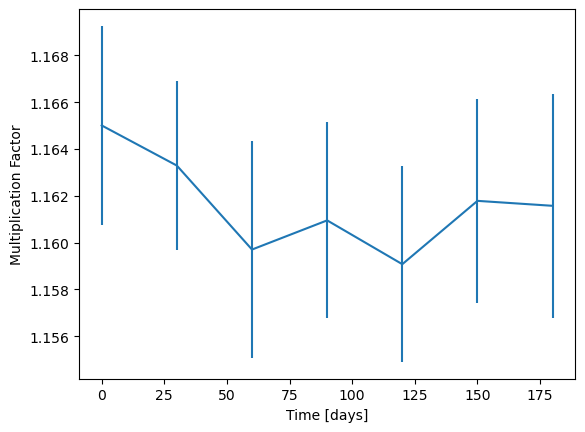

In [19]:
plt.errorbar(time, k[:,0], yerr=k[:,1])
plt.xlabel('Time [days]')
plt.ylabel('Multiplication Factor')

In [20]:
_, u5 = results.get_atoms(fuel_material, "U235", nuc_units='atom/b-cm')
_, xe135 = results.get_atoms(fuel_material, "Xe135", nuc_units='atom/b-cm')

Text(0, 0.5, 'U235 Concentration [atom/b-cm]')

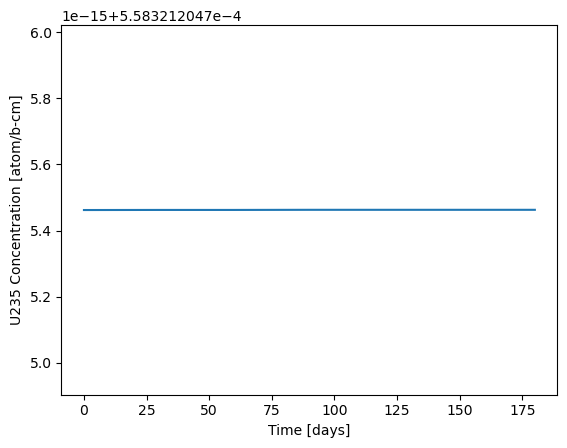

In [21]:
plt.plot(time, u5, label='U235')
plt.xlabel('Time [days]')
plt.ylabel('U235 Concentration [atom/b-cm]')

Text(0, 0.5, 'Xe135 Concentration [atom/b-cm]')

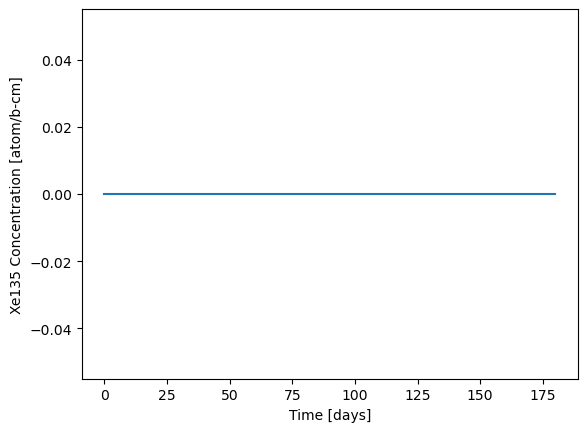

In [24]:
plt.plot(time, xe135, label='Xe135')
plt.xlabel('Time [days]')
plt.ylabel('Xe135 Concentration [atom/b-cm]')

In [25]:
_, u5_fission = results.get_reaction_rate(fuel_material, "U235", "fission")

Text(0, 0.5, 'Fission Reaction Rate [rxns/s]')

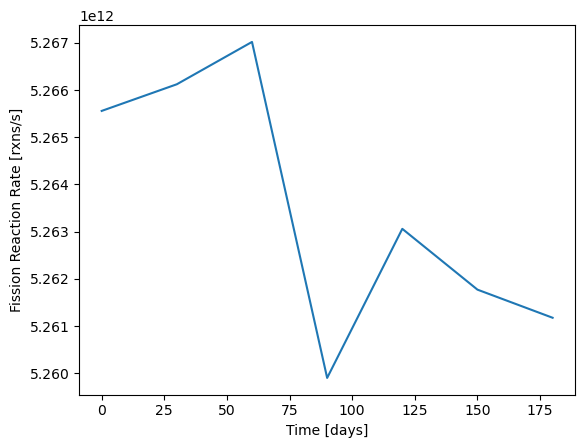

In [26]:
plt.plot(time, u5_fission)
plt.xlabel('Time [days]')
plt.ylabel('Fission Reaction Rate [rxns/s]')

## Depletion Integrators

In [27]:
long_steps = [60, 60, 60]

In [28]:
operator = openmc.deplete.CoupledOperator(model)
cecm_int = openmc.deplete.CECMIntegrator(operator, long_steps, power, timestep_units='d')

In [29]:
cecm_int.integrate()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

<ErrorbarContainer object of 3 artists>

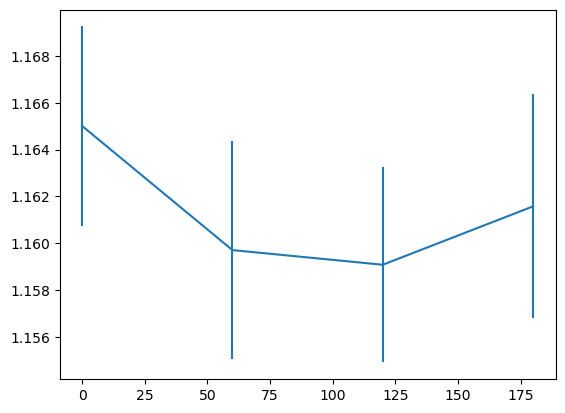

In [30]:
results = openmc.deplete.Results('depletion_results.h5')
time,k = results.get_keff()
time /= (24 * 60 * 60)
plt.errorbar(time, k[:,0], k[:,1])

## Integration Timestep/Power Options

In [32]:
timesteps = [(30, 'd'), (30, 'd'), (6.7, 'h'), (6.7, 'h'), (6.7, 'h')]
power = [174., 174., 0., 0., 0.]

operator = openmc.deplete.CoupledOperator(model)
dep_int = openmc.deplete.CECMIntegrator(operator, timesteps, power, timestep_units='d')
dep_int.integrate()

                                %%%%%%%%%%%%%%%
                           %%%%%%%%%%%%%%%%%%%%%%%%
                        %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                      %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                    %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                   %%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
                                    %%%%%%%%%%%%%%%%%%%%%%%%
                                     %%%%%%%%%%%%%%%%%%%%%%%%
                 ###############      %%%%%%%%%%%%%%%%%%%%%%%%
                ##################     %%%%%%%%%%%%%%%%%%%%%%%
                ###################     %%%%%%%%%%%%%%%%%%%%%%%
                ####################     %%%%%%%%%%%%%%%%%%%%%%
                #####################     %%%%%%%%%%%%%%%%%%%%%
                ######################     %%%%%%%%%%%%%%%%%%%%
                #######################     %%%%%%%%%%%%%%%%%%
                 #######################     %%%%%%%%%%%%%%%%%
                 #####################

<ErrorbarContainer object of 3 artists>

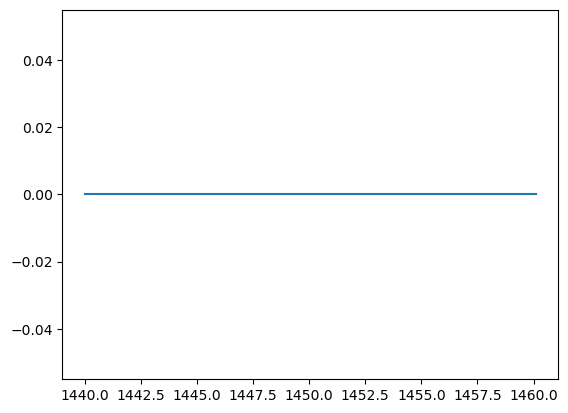

In [34]:
results = openmc.deplete.Results('depletion_results.h5')
time,i135 = results.get_atoms(fuel_material, 'I135', time_units='h', nuc_units='atom/b-cm')
plt.errorbar(time[-4:], i135[-4:])

## Normalization (energy) modes

penmc.deplete.CoupledOperator(..., normalization_mode="fission-q")  # fixed Q values for fission <br>
openmc.deplete.CoupledOperator(..., normalization_mode="energy-deposition")  # explicit heating tallies <br>
openmc.deplete.CoupledOperator(..., normalization_mode="source-rate")  # for fixed source (activation) calculation <br>

## Choice of Depletion Step Size

In [35]:
operator.heavy_metal
power = 174

In [36]:
max_step = 2 * operator.heavy_metal / power * 1e3

In [39]:
print(f"'Maximum' Depletion Step: {max_step:5.3} [days]")

'Maximum' Depletion Step: 1.3e+02 [days]


## Differentiating Burnable Materials

<Axes: xlabel='x [cm]', ylabel='y [cm]'>

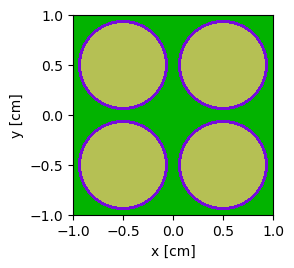

In [44]:
new_model = openmc.Model()
new_model.settings = model.settings

radii = [0.42, 0.45]
pitch = 1
# Create materials for fuel, clad, and water
fuel = openmc.Material(name="uo2")
fuel.add_element("U", 1, percent_type="ao", enrichment=4.25)
fuel.add_element("O", 2)
fuel.set_density("g/cc", 10.4)
fuel.volume = 4 * math.pi * radii[0] ** 2

clad = openmc.Material(name="clad")
clad.add_element("Zr", 1)
clad.set_density("g/cc", 6)

water = openmc.Material(name="water")
water.add_element("O", 1)
water.add_element("H", 2)
water.set_density("g/cc", 1.0)
water.add_s_alpha_beta("c_H_in_H2O")
model.materials = openmc.Materials([fuel, clad, water])

# Create a fuel pin universe
radii = [0.42, 0.45]
pin_surfaces = [openmc.ZCylinder(r=r) for r in radii]
materials = [fuel, clad, water]
pin_univ = openmc.model.pin(pin_surfaces, model.materials)

lattice = openmc.RectLattice()
lattice.lower_left = (-pitch, -pitch)
lattice.pitch = (pitch, pitch)
lattice.universes = [
    [pin_univ, pin_univ],
    [pin_univ, pin_univ]
]
lattice.outer = pin_univ

# Put it into a single cell defined as a box with reflective boundary conditions
bound_box = openmc.model.RectangularPrism(2*pitch, 2*pitch, boundary_type="reflective")
root_cell = openmc.Cell(fill=lattice, region=-bound_box)
new_model.geometry = openmc.Geometry([root_cell])

new_model.geometry.root_universe.plot(width=(2*pitch, 2*pitch))

In [1]:
new_op = openmc.deplete.CoupledOperator(new_model, diff_burnable_mats=True)
integrator = openmc.deplete.PredictorIntegrator(new_op, time_steps, power, timestep_units='d')
integrator.integrate()

NameError: name 'openmc' is not defined